In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit

from models.multiGaussian import MultiGaussianAdaptedSkiRental
from models.varianceAware import VarianceAwareSkiRental
from models.expectedCost import ExpectedCostSkiRental
from models.bayesian import BayesianSkiRental
from models.hybrid import HybridVarianceAwareSkiRental, HybridVarianceAwareSkiRentalWithScaling
from models.gaussianNoise import GaussianNoiseSkiRental
from models.bayesianDiscrete import DiscreteBayesianSkiRental


In [2]:
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)
logging.getLogger("pytensor").setLevel(logging.ERROR)


 # Experiment 1 

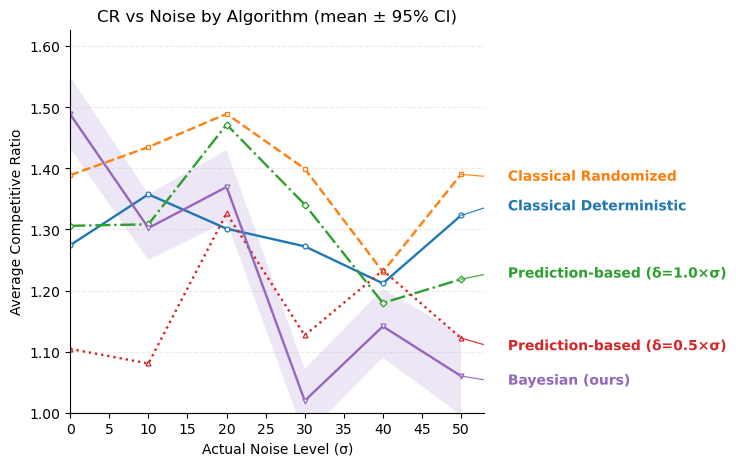

Saved: figs-final/exp1.png


In [ ]:
# -------------------------------------------------
# (6) 플로팅: 선 끝 라벨링(legend 제거, PNG만 저장) — 수평 연장 제거 버전
# -------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ===== 데이터 준비: agg 없으면 샘플 생성 =====
if 'agg' not in globals():
    np.random.seed(0)
    algos = [
        "Classical Deterministic",
        "Classical Randomized",
        "Prediction-based (δ=1.0×σ)",
        "Prediction-based (δ=0.5×σ)",
        "Bayesian (ours)"
    ]
    # 일부 알고리즘은 50까지만, 일부는 100까지 만들어 상황 재현
    rows = []
    for algo in algos:
        if algo in ["Classical Deterministic", "Bayesian (ours)"]:
            noise_levels = np.arange(0, 101, 10)   # 0..100
        else:
            noise_levels = np.arange(0, 51, 10)    # 0..50 (이후 없음)

        mean   = 1.05 + 0.45 * np.random.rand(len(noise_levels))
        ci_low = mean - 0.05 - 0.02 * np.random.rand(len(noise_levels))
        ci_high= mean + 0.05 + 0.02 * np.random.rand(len(noise_levels))
        for n, m, lo, hi in zip(noise_levels, mean, ci_low, ci_high):
            rows.append((algo, n, m, lo, hi))
    agg = pd.DataFrame(rows, columns=["algorithm", "noise", "mean", "ci_low", "ci_high"])

# ===== 스타일/순서 =====
order      = agg["algorithm"].unique().tolist()
palette    = list(plt.get_cmap("tab10").colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "X", "P"]

# ===== 플롯 시작 =====
fig, ax = plt.subplots(figsize=(7.6, 4.8))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo].copy()
    if tmp.empty:
        continue

    # 안전: numeric + 정렬
    for col in ["noise", "mean", "ci_low", "ci_high"]:
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
    tmp = tmp.dropna(subset=["noise", "mean"]).sort_values("noise")

    # >>> 핵심: 패딩/재색인/보간으로 '뒤를 채우지 않음' (수평선 방지)
    x = tmp["noise"].to_numpy()
    y = tmp["mean"].to_numpy()
    lo = tmp["ci_low"].to_numpy()
    hi = tmp["ci_high"].to_numpy()

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 우리 모델만 신뢰구간 음영 (있는 구간까지만)
    if algo == "Bayesian (ours)":
        ax.fill_between(x, lo, hi, alpha=0.16, facecolor=color, edgecolor="none")

    # 모든 모델 라인 + 마커 (있는 구간까지만)
    ax.plot(x, y, linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
            markerfacecolor="white", markeredgewidth=0.9, color=color)

    # 라벨용 끝점 = 실제 마지막 데이터 지점
    x_last = float(x[-1])
    y_last = float(y[-1])
    end_points.append((algo, x_last, y_last, color))

# ===== 축/눈금/타이틀 =====
ax.set_xlabel("Actual Noise Level (σ)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Noise by Algorithm (mean ± 95% CI)")
ax.set_xlim(0, 53)
ax.set_xticks(np.arange(0, 53, 10))
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.xaxis.set_major_locator(MaxNLocator(nbins=11, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ===== 선 끝 라벨링 (충돌 방지) =====
end_points.sort(key=lambda t: t[2])  # y 기준 정렬
yrange  = y_max - y_min
xpad    = 6.0
min_sep = 0.035 * yrange
base_dy = 0.012 * yrange
N = len(end_points)

lin_offsets = np.linspace(-base_dy, base_dy, num=max(N, 1))
desired_y = {ep[0]: np.clip(ep[2] + off, y_min + 0.01*yrange, y_max - 0.01*yrange)
             for off, ep in zip(lin_offsets, end_points)}

group_nudge = {
    "Classical Deterministic":      +0.018 * yrange,
    "Classical Randomized":         -0.018 * yrange,
    "Prediction-based (δ=1.0×σ)":   +0.015 * yrange,
    "Prediction-based (δ=0.5×σ)":   -0.015 * yrange,
    "Bayesian (ours)":               0.0,
}
for algo, _, _, _ in end_points:
    desired_y[algo] = float(np.clip(
        desired_y[algo] + group_nudge.get(algo, 0.0),
        y_min + 0.01*yrange, y_max - 0.01*yrange
    ))

# 아래→위, 위→아래 스윕
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

# 연결선 + 텍스트
pos_map = dict(placed)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map.get(algo, y_last)
    ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)
    ax.text(x_last + xpad, y_lab, algo, color=color, fontsize=10,
            va='center', ha='left', fontweight='semibold',
            path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)])

fig.tight_layout(pad=1.2)

# ===== 저장(PNG만) =====
os.makedirs("figs-final", exist_ok=True)
out_png = "figs-final/exp1.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")
